In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

GPT_INPUT_FILE = os.path.join(root,'templates/sectormagnet/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root, 'templates/sectormagnet/distgen.in.yaml')

This notebook implements the automated generation of a single sectorbend lattice in GPT.  This is accomplished using `gpt.Sectorbend_zx`.  The beam here is effectively a single particle at 10 MeV/c momentum, and is created using distgen:

In [2]:
from distgen import Generator
gen = Generator(DISTGEN_INPUT_FILE, verbose=1)
gen.run()
pg = gen.particles

Distribution format: gpt
Output file: gpt_particles.txt

Creating beam distribution....
   Beam starting from: time
   Total charge: 1 pC.
   Number of macroparticles: 10.
   Time start: fixing all particle time values to start time: 0 ps.
      Setting avg_t -> 0 s.
   Applying user supplied transform: "t1" = set_avg pz...
      Setting avg_pz -> 10 MeV/c.
...done. Time Ellapsed: 14.0591 ms.

   Created particles in .particles: ParticleGroup with 10 particles with total charge 1e-12 C

As mentioned before the sectormagnet is defined using `gpt.Sectorbend_zx`.  See the doc string for details of this object:

Sectormagnet b1 CCS rotation matrix was specified by a single number: assuming this is the z-x rotation angle [deg]...


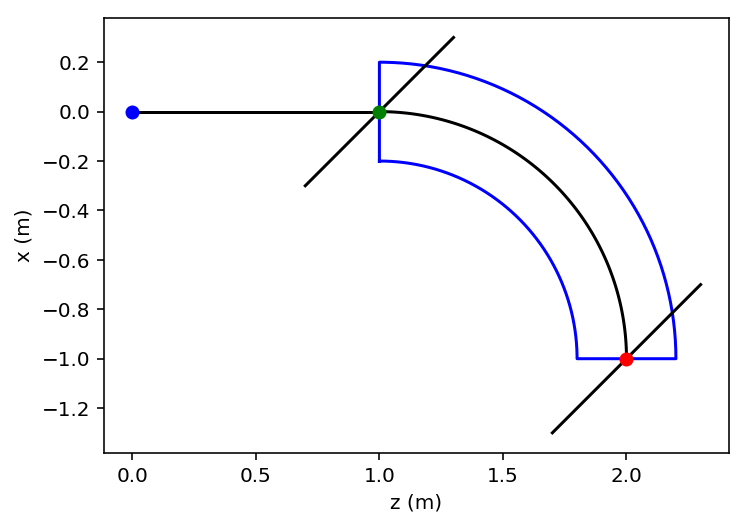

In [3]:
import numpy as np
R=1
p = np.mean(pg['p'])

from gpt.bends import Sectormagnet_zx
sec = Sectormagnet_zx('b1', R, -90, p, 'wcs', [0, 0, 0], 0, ds=1, phi_in=-45, phi_out=-45, dipole_width=0.2)
sec.plot(axis='equal')

Here the beam starts at the blue dot and the sectormagnet is set to have pole face edges that make it a rectangular bend, as is shown with the black liness for the pole faces.  First, read in the template GPT inputfile, and then

In [12]:
from distgen import Generator
gen = Generator(DISTGEN_INPUT_FILE, verbose=1)
gen.run()
pg = gen.particles

Distribution format: gpt
Output file: gpt_particles.txt

Creating beam distribution....
   Beam starting from: time
   Total charge: 1 pC.
   Number of macroparticles: 10.
   Time start: fixing all particle time values to start time: 0 ps.
      Setting avg_t -> 0 s.
   Applying user supplied transform: "t1" = set_avg pz...
      Setting avg_pz -> 10 MeV/c.
...done. Time Ellapsed: 18.6629 ms.

   Created particles in .particles: ParticleGroup with 10 particles with total charge 1e-12 C

In [16]:
fid = open(GPT_INPUT_FILE,'r')

lines = []
for line in fid:
    lines.append(line)
fid.close()

lines = lines

with open('gpt.temp.in','w') as fid:
    
    for line in sec.gpt_lines():
        lines.append(line+'\n')
    
    for line in lines:
        #print(line)
        fid.write(line)

from gpt import GPT

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.run()
print(G)


GPT object:
   Original input file: gpt.temp.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/examples
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp6xydaeac
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.0654301643371582 (sec)


To see the results, plot the orbit of the bunch overlayed on the sectormagnet plot.  This is shown below, with the orbit of the bunch computed from GPT show in light blue.

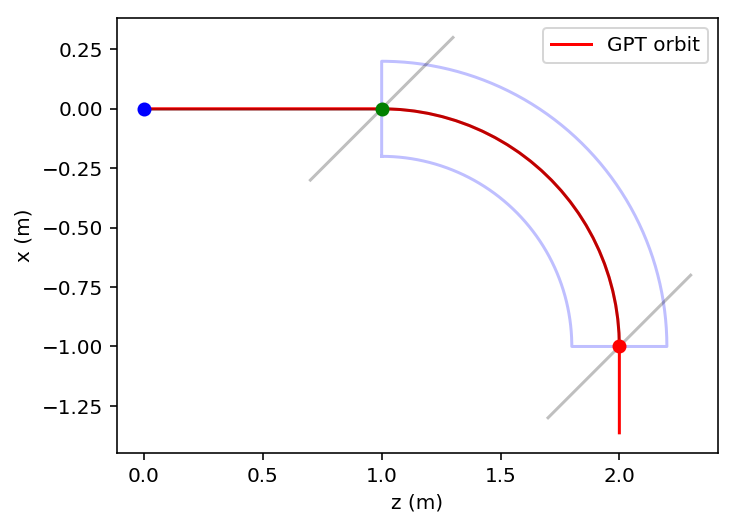

In [30]:
from matplotlib import pyplot as plt

plt.plot(G.stat('mean_z')[:-1], G.stat('mean_x')[:-1], 'r')
sec.plot(axis='equal', alpha=0.25)
plt.gca().set_aspect('equal')
plt.legend(['GPT orbit']);

In [21]:
from mpl_toolkits.mplot3d import Axes3D

t1 = G.trajectory(1, data_type='tout')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

legend = []

for ii in range(0,70):
    
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        ax.plot(tii['x'], tii['y']*1000, tii['z'], zdir='x')
        #print(f'particle id = {ii},', f'mean x pos = {tii["x"].mean()}')

ax.set_xlabel('z (m)');
ax.set_ylabel('x (m)');
ax.set_zlabel('y (mm)');

In [32]:
os.system(f'rm gpt.temp.in');